# Name: Ashwin Shetty
# USC ID: 38407473

## CNN for image colorization

In [1]:
import pandas as pd
import numpy as np
import os
import io
from sklearn.preprocessing import MinMaxScaler
import string
import re
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.2.0


## Q2

## Loading bird image data from cifar10

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

index = np.where(y_train == 2)
X_train = X_train[index[0]]
y_train = y_train[index[0]]

index = np.where(y_test == 2)
X_train = np.append(X_train, X_test[index[0]], 0)
y_train = np.append(y_train, y_test[index[0]], 0)

170500096/170498071 [==============================] - 2s 0us/step


## Creating image vectors for RGB channels

In [4]:
X = X_train
X = np.reshape(X,[-1,X.shape[3]])
print(X.shape)

(6144000, 3)


## Setting number of clusters and finding color centers using KMeans algorithm

In [7]:
m = 4

In [8]:
kmeans = KMeans(n_clusters= m).fit(X)
centers= kmeans.cluster_centers_
labels = kmeans.labels_


## Assigning RGB channel of images to nearest color centers using Euclidean distance

In [9]:
X_copy = np.zeros([X.shape[0],X.shape[1]])
for i in range(X.shape[0]):
    X_copy[i][:] = centers[labels[i]]


## Using one hot encoding for labels

In [11]:
lb = LabelBinarizer()
y_train = lb.fit_transform(labels)
y_train = np.reshape(y_train, [-1, 32,32,m])

## Converting images to grayscale to serve as input images

In [12]:
from skimage.color import rgb2gray
Xg = []
for i in range(X_train.shape[0]):
    Xg.append(rgb2gray(X_train[i]))
X_gray = np.asarray(Xg)

## Defining model architecture

In [14]:
model = Sequential()
# BLOCK 1
model.add(layers.Conv2D(32, (5,5), activation='relu', input_shape=(32, 32, 1), padding = 'same'))
model.add(layers.MaxPooling2D((2, 2),strides = (1,1), padding = 'same'))
# BLOCK 2
model.add(layers.Conv2D(64, (5,5), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2), strides = (1,1), padding = 'same'))
# BLOCK 3
model.add(layers.Conv2D(64, (5,5), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2),strides = (1,1), padding = 'same'))
# BLOCK 4
model.add(layers.Dropout(0.2))
# FULLY CONNECTED
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(m, activation='softmax'))

## Defining model loss function, optimizer and monitor metric

In [15]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', metrics=["accuracy"])

## Train test split of data

In [16]:
X_gray_train, X_gray_test, y_gray_train, y_test_gray = train_test_split(X_gray.reshape(-1,32,32,1), y_train, test_size = 0.1 )

## Creating early stop, weight saving checkpoints and training model

In [17]:
filepath="cnn_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
earlyStoppingCk = keras.callbacks.EarlyStopping(patience = 2, min_delta = 1e-4)
callbacks_list = [checkpoint, earlyStoppingCk]
history = model.fit(X_gray_train, y_gray_train, epochs=30, 
                    validation_split=0.1, batch_size = 8, callbacks = callbacks_list)
        

Train on 4860 samples, validate on 540 samples
Epoch 1/30
4860/4860 [==============================] - 142s 29ms/step - loss: 0.5817 - accuracy: 0.7452 - val_loss: 0.4053 - val_accuracy: 0.8263

Epoch 00001: loss improved from inf to 0.58171, saving model to weights-improvement-01-0.5817.hdf5
Epoch 2/30


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


4860/4860 [==============================] - 140s 29ms/step - loss: 0.4375 - accuracy: 0.8100 - val_loss: 0.4609 - val_accuracy: 0.7946

Epoch 00002: loss improved from 0.58171 to 0.43753, saving model to weights-improvement-02-0.4375.hdf5
Epoch 3/30
4860/4860 [==============================] - 143s 29ms/step - loss: 0.4083 - accuracy: 0.8226 - val_loss: 0.3635 - val_accuracy: 0.8417

Epoch 00003: loss improved from 0.43753 to 0.40826, saving model to weights-improvement-03-0.4083.hdf5
Epoch 4/30
4860/4860 [==============================] - 148s 30ms/step - loss: 0.3890 - accuracy: 0.8330 - val_loss: 0.3529 - val_accuracy: 0.8473

Epoch 00004: loss improved from 0.40826 to 0.38896, saving model to weights-improvement-04-0.3890.hdf5
Epoch 5/30
4860/4860 [==============================] - 144s 30ms/step - loss: 0.3798 - accuracy: 0.8357 - val_loss: 0.3460 - val_accuracy: 0.8480

Epoch 00005: loss improved from 0.38896 to 0.37985, saving model to weights-improvement-05-0.3798.hdf5
Epoch 6

## Loading model weights

In [ ]:
model.load_weights('cnn_weights.hdf5')

## Plotting train loss and validation loss

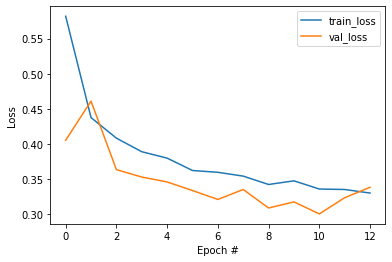

In [19]:
epo = np.arange(len(history.history["loss"]))
plt.plot(epo, history.history["loss"], label="train_loss")
plt.plot(epo, history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

## Comparing 10 model outputs to original colored output

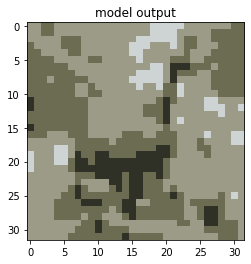

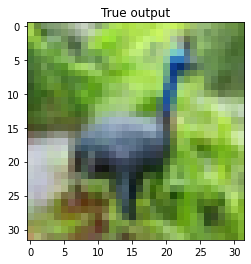

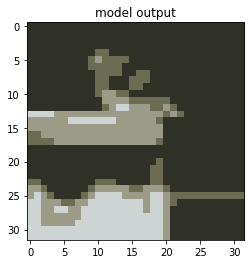

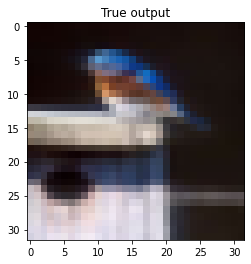

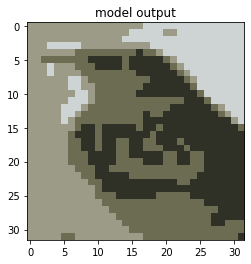

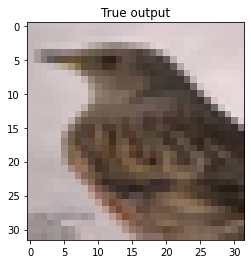

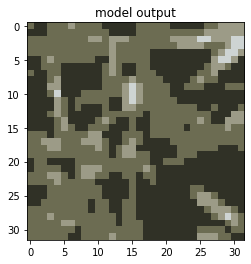

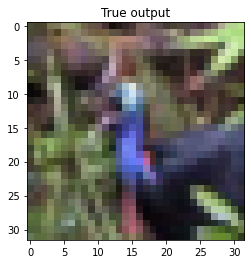

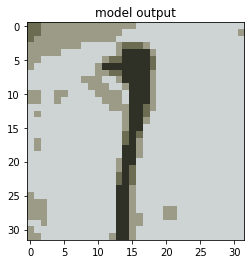

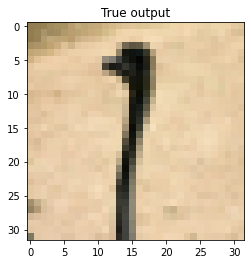

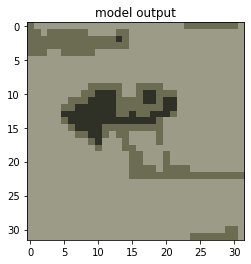

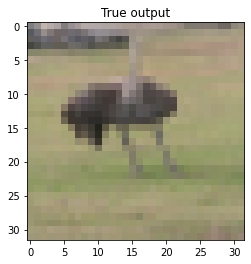

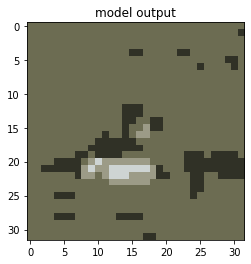

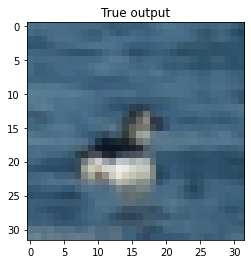

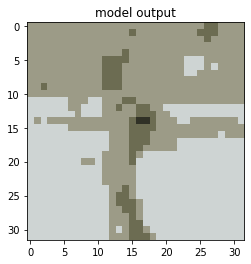

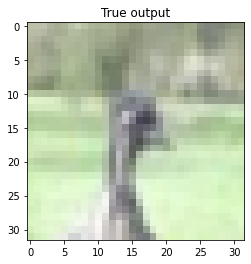

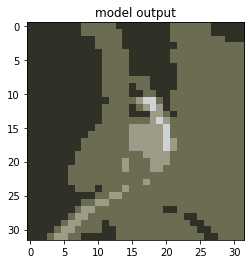

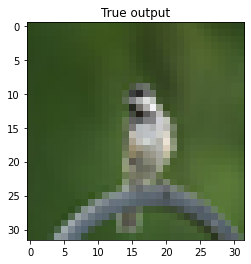

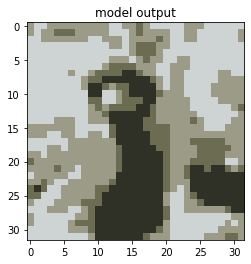

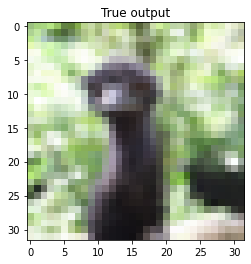

In [21]:
from skimage.color import rgb2gray
for num in range(10):
  pred = model.predict(rgb2gray(X_train[num]).reshape(1,32,32,1))
  pred = np.reshape(pred,[-1,m])
  new_pred = np.zeros([1024,3])
  for i in range(pred.shape[0]):
     c = centers[np.argmax(pred[i])]
     new_pred[i] = c
  plt.figure(num)
  plt.imshow(new_pred.reshape(32,32,3).astype('int'))
  plt.title('model output')
  plt.figure(10+num)
  plt.imshow(X_train[num])
  plt.title('True output')


